# Recurrent Neural Net Part 2

This notebook is based on a tutorial: "Multivariate Time Series using RNN with Keras" from [here](https://medium.com/datadriveninvestor/multivariate-time-series-using-rnn-with-keras-7f78f4488679)



## Meeting Agenda



1.   Project Updates

- Phil 
  - https://www.edx.org/bio/robert-van-de-geijn
  - Pink Zybo - board that executes Python on an FPGA - [pynq.io](https://pynq.io)

- Chuck - IBM Watson templates - learning Python

- J - RNN for soil moisture prediction

- Nick - Web app called "Improved Initiative" - manages attributes of D&D characters. Nick working on importing stat blocks.

- Phil - MDA Small Business Conference June 25-26

2.   SBIR Brainstorm Session Updates

 - MDA 19-005 Topic
 - MDA 19-011 Topic
 - Additional session to follow tonight
 
3.   RNN Code Walkthrough


## RNN Example Code

In [0]:
import numpy as np
import pandas as pd
import math
from keras import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
total_training = []
total_validation = []



Using TensorFlow backend.


First, we download a csv export of the Google stock from [here](https://www.nasdaq.com/symbol/goog/historical).

For convenience, this is saved in the presentations repository and can be access by URL.

**Note:** 

We need to use the thousands=',' parameter in order to ignore the commas in the numbers when converting to floats.

We'll use the head() method to get a look at what the dataframe looks like.

In [0]:
fileURL = "https://github.com/HSV-AI/presentations/raw/master/2019/190619/HistoricalQuotes.csv"
stock_data = pd.read_csv(fileURL, thousands=',')
stock_data.head(2)

,date,close,volume,open,high,low
0,16:00,1103.6,1386584.0,1107.82,1116.39,1098.99
1,2019/06/18,1103.6,1386684.0,1109.69,1116.39,1098.99


In [0]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1260 entries, 0 to 1259
Data columns (total 6 columns):
date      1260 non-null object
close     1260 non-null float64
volume    1260 non-null float64
open      1260 non-null float64
high      1260 non-null float64
low       1260 non-null float64
dtypes: float64(5), object(1)
memory usage: 59.1+ KB


In [0]:

stock_data["average"] = (stock_data["high"] + stock_data["low"])/2
stock_data.head(5)


,date,close,volume,open,high,low,average
0,16:00,1103.60,1386584.0,1107.82,1116.39,1098.9900,1107.69000
1,2019/06/18,1103.60,1386684.0,1109.69,1116.39,1098.9900,1107.69000
2,2019/06/17,1092.50,941602.0,1086.28,1099.18,1086.2800,1092.73000
3,2019/06/14,1085.35,1111643.0,1086.42,1092.69,1080.1721,1086.43105
4,2019/06/13,1088.77,1058000.0,1083.64,1094.17,1080.1500,1087.16000


In [0]:
input_feature= stock_data.iloc[:,[2,6]].values
input_data = input_feature
input_feature.shape

output_feature = stock_data.iloc[:,3].values

print(input_feature.shape)
print(output_feature.shape)

(1260, 2)
(1260,)


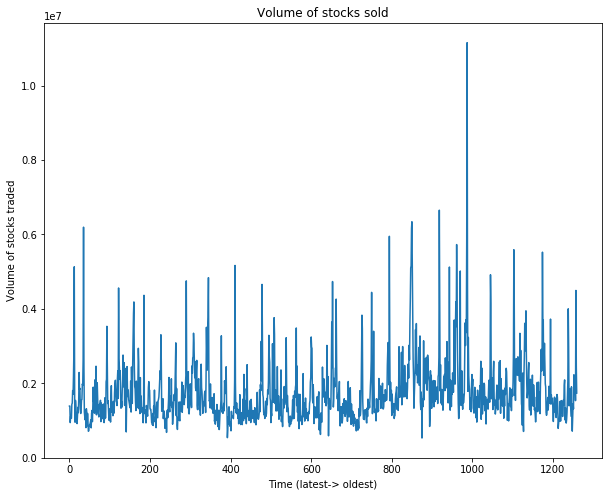

In [0]:
plt.figure(figsize=(10,8))
plt.plot(input_feature[:,0])
plt.title("Volume of stocks sold")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("Volume of stocks traded")
plt.show()

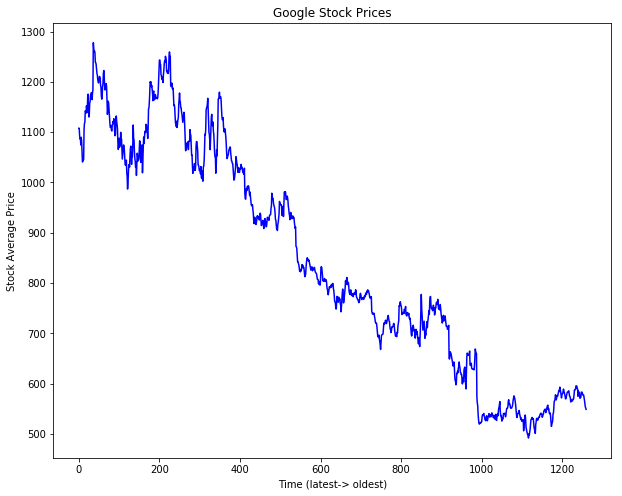

In [0]:
plt.figure(figsize=(10,8))
plt.plot(input_feature[:,1], color='blue')
plt.title("Google Stock Prices")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("Stock Average Price")
plt.show()

In [0]:
input_scaler = MinMaxScaler(feature_range=(0,1))
input_data[:,0:2] = input_scaler.fit_transform(input_feature[:,:])

output_scaler = MinMaxScaler(feature_range=(0,1))
output_feature = output_feature.reshape(-1, 1)
output_data = output_scaler.fit_transform(output_feature)

In [0]:
lookback= 50

X=[]
y=[]
for i in range(len(stock_data)-lookback-1):
    t=[]
    for j in range(0,lookback):
        t.append(input_data[[(i+j)], :])

    X.append(t)
    y.append(output_data[i+ lookback])

In [0]:
X, y= np.array(X), np.array(y)
X = X.reshape(X.shape[0],lookback, 2)
print(X.shape)
print(y.shape)

(1209, 50, 2)
(1209, 1)


In [0]:
model = Sequential()
model.add(LSTM(units=30, return_sequences= True, input_shape=(X.shape[1],2)))
model.add(LSTM(units=30, return_sequences=True))
model.add(LSTM(units=30))
model.add(Dense(units=1))
model.summary()


W0624 13:04:41.986785 140576409040768 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0624 13:04:42.034794 140576409040768 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0624 13:04:42.041717 140576409040768 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 30)            3960      
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 30)            7320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 18,631
Trainable params: 18,631
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer='adam', loss='mean_squared_error')

W0624 13:04:42.763016 140576409040768 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



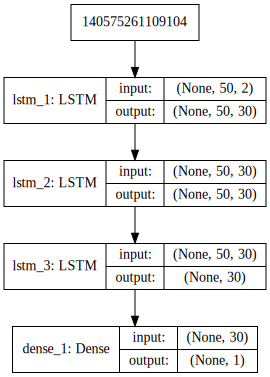

In [0]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [0]:
def plot_loss(history):

  length = len(history.history['loss'])
  rng = range(length)

  training_fit = np.polyfit(rng, history.history['loss'], 1)
  training_trend = np.poly1d(training_fit)

  val_fit = np.polyfit(rng, history.history['val_loss'], 1)
  val_trend = np.poly1d(val_fit)

  plt.figure(figsize=(10,8))
  plt.plot(history.history['loss'], color='green')
  plt.plot(training_trend(rng), color='green', linestyle='--')
  plt.plot(history.history['val_loss'], color='orange')
  plt.plot(val_trend(rng), color='orange', linestyle='--')

  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Training Trend', 'Validation', 'Validation Trend'], loc='lower left')
  plt.show()


Originally, we had this line:

history = model.fit(X, y, validation_split=0.30, epochs=50, batch_size=32, verbose=1)

The problem is that the validation split always takes the validation off of the back of the data, instead of randomly selecting 30% for validation.

To change this up, we will use the train_test_split from sklearn to give us a random 30% validation set. Then we will train for 50 epochs and graph the training loss and validation loss to see how we're doing.

We will repeat this for a few times to see how low the error drops.


W0624 13:04:43.583152 140576409040768 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0624 13:04:45.474774 140576409040768 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0624 13:04:45.633028 140576409040768 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 846 samples, validate on 363 samples
Epoch 1/50
846/846 [==============================] - 5s 6ms/step - loss: 0.0675 - val_loss: 0.0144
Epoch 2/50
846/846 [==============================] - 3s 3ms/step - loss: 0.0047 - val_loss: 0.0023
Epoch 3/50
846/846 [==============================] - 2s 3ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 4/50
846/846 [==============================] - 2s 3ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 5/50
846/846 [==============================] - 2s 3ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 6/50
846/846 [==============================] - 2s 3ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 7/50
846/846 [==============================] - 2s 3ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 8/50
846/846 [==============================] - 2s 3ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 9/50
846/846 [==============================] - 2s 3ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 10/50
846/846 [==============================] -

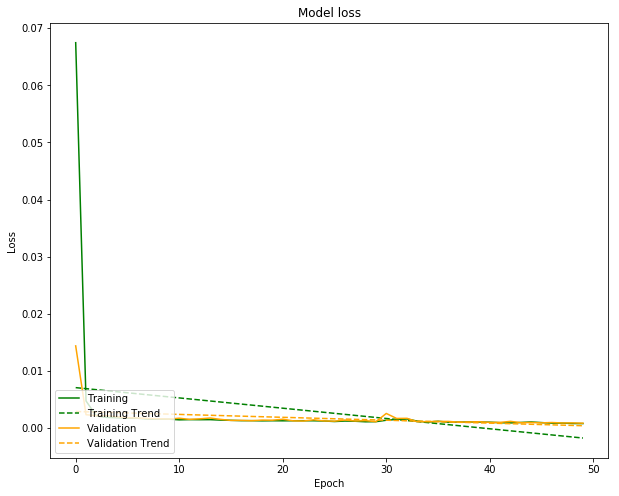

Train on 846 samples, validate on 363 samples
Epoch 1/50
846/846 [==============================] - 3s 3ms/step - loss: 8.1719e-04 - val_loss: 9.6358e-04
Epoch 2/50
846/846 [==============================] - 2s 3ms/step - loss: 9.1981e-04 - val_loss: 8.8211e-04
Epoch 3/50
846/846 [==============================] - 2s 3ms/step - loss: 9.2790e-04 - val_loss: 8.7396e-04
Epoch 4/50
846/846 [==============================] - 3s 3ms/step - loss: 7.8762e-04 - val_loss: 6.5688e-04
Epoch 5/50
846/846 [==============================] - 3s 3ms/step - loss: 7.6310e-04 - val_loss: 6.3435e-04
Epoch 6/50
846/846 [==============================] - 3s 3ms/step - loss: 7.5269e-04 - val_loss: 6.4268e-04
Epoch 7/50
846/846 [==============================] - 3s 3ms/step - loss: 7.5958e-04 - val_loss: 6.3325e-04
Epoch 8/50
846/846 [==============================] - 2s 3ms/step - loss: 7.2086e-04 - val_loss: 6.1772e-04
Epoch 9/50
846/846 [==============================] - 3s 3ms/step - loss: 7.8046e-04 - val

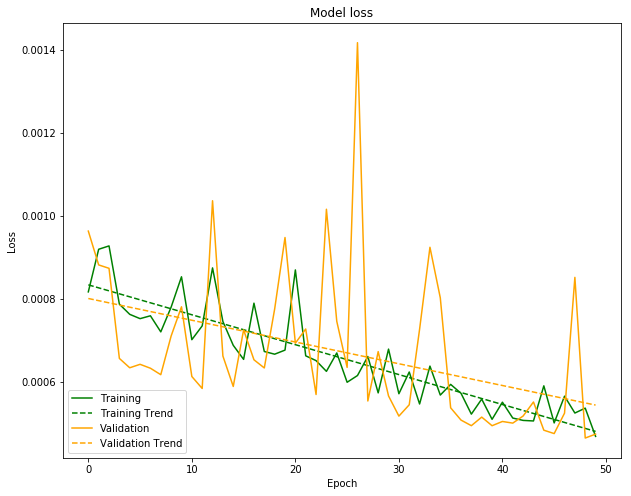

Train on 846 samples, validate on 363 samples
Epoch 1/50
846/846 [==============================] - 2s 3ms/step - loss: 4.7266e-04 - val_loss: 6.8309e-04
Epoch 2/50
846/846 [==============================] - 2s 3ms/step - loss: 4.4833e-04 - val_loss: 5.1969e-04
Epoch 3/50
846/846 [==============================] - 3s 3ms/step - loss: 5.2883e-04 - val_loss: 5.3983e-04
Epoch 4/50
846/846 [==============================] - 2s 3ms/step - loss: 4.8203e-04 - val_loss: 5.4884e-04
Epoch 5/50
846/846 [==============================] - 3s 3ms/step - loss: 4.3820e-04 - val_loss: 5.1928e-04
Epoch 6/50
846/846 [==============================] - 3s 3ms/step - loss: 6.1912e-04 - val_loss: 0.0014
Epoch 7/50
846/846 [==============================] - 3s 3ms/step - loss: 4.9257e-04 - val_loss: 5.2084e-04
Epoch 8/50
846/846 [==============================] - 3s 3ms/step - loss: 4.6684e-04 - val_loss: 4.8340e-04
Epoch 9/50
846/846 [==============================] - 2s 3ms/step - loss: 4.6687e-04 - val_los

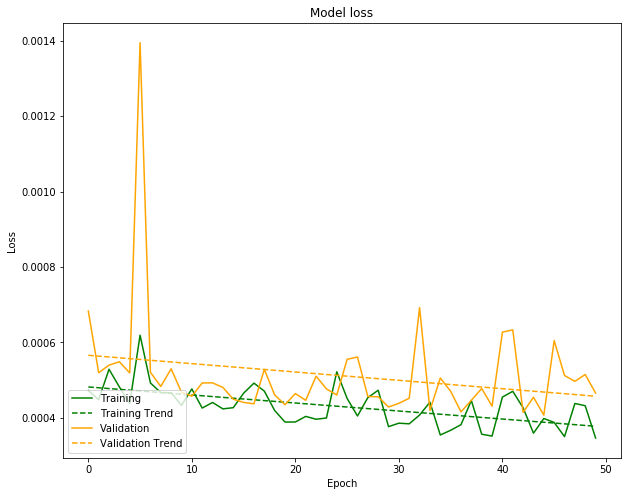

Train on 846 samples, validate on 363 samples
Epoch 1/50
846/846 [==============================] - 3s 3ms/step - loss: 3.6116e-04 - val_loss: 4.3664e-04
Epoch 2/50
846/846 [==============================] - 2s 3ms/step - loss: 3.8598e-04 - val_loss: 4.1003e-04
Epoch 3/50
846/846 [==============================] - 3s 3ms/step - loss: 3.5837e-04 - val_loss: 3.9779e-04
Epoch 4/50
846/846 [==============================] - 3s 3ms/step - loss: 3.6735e-04 - val_loss: 3.7441e-04
Epoch 5/50
846/846 [==============================] - 2s 3ms/step - loss: 3.6283e-04 - val_loss: 5.6940e-04
Epoch 6/50
846/846 [==============================] - 2s 3ms/step - loss: 4.5007e-04 - val_loss: 3.7363e-04
Epoch 7/50
846/846 [==============================] - 2s 3ms/step - loss: 3.6223e-04 - val_loss: 4.2357e-04
Epoch 8/50
846/846 [==============================] - 2s 3ms/step - loss: 3.7351e-04 - val_loss: 3.7106e-04
Epoch 9/50
846/846 [==============================] - 3s 3ms/step - loss: 3.6970e-04 - val

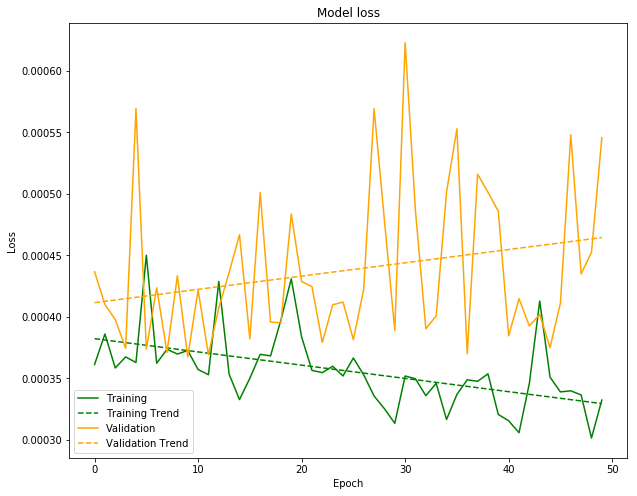

In [0]:
for i in range(4):
  XTraining, XValidation, YTraining, YValidation = train_test_split(X,y,test_size=0.3) # before model building
  history = model.fit(XTraining, YTraining, batch_size=32, epochs=50, validation_data=(XValidation,YValidation))
  total_training.extend(history.history['loss'])
  total_validation.extend(history.history['val_loss'])
  
  # Plot training & validation loss values
  plot_loss(history)


Now we'll take a look at the final results of the training/validation error. We throw out the first 10 epochs of training, as they vary wildly before any real training begins.

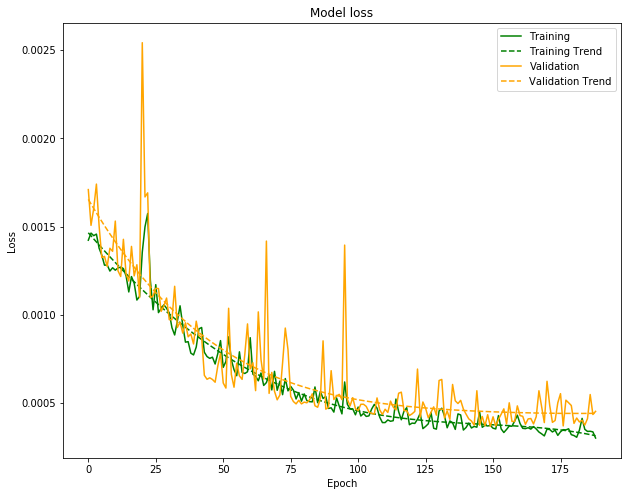

In [0]:
length = len(total_training[10:-1])
rng = range(length)

training_fit = np.polyfit(rng, total_training[10:-1], 4)
training_trend = np.poly1d(training_fit)

val_fit = np.polyfit(rng, total_validation[10:-1], 4)
val_trend = np.poly1d(val_fit)

plt.figure(figsize=(10,8))
plt.plot(total_training[10:-1], color='green')
plt.plot(training_trend(rng), color='green', linestyle='--')
plt.plot(total_validation[10:-1], color='orange')
plt.plot(val_trend(rng), color='orange', linestyle='--')

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Training Trend', 'Validation', 'Validation Trend'], loc='upper right')
plt.show()


In [0]:
predicted_value = model.predict(X)
unscaled_output = output_scaler.inverse_transform(predicted_value)

temp = np.array(stock_data.open[lookback:-1]).reshape(-1,1)


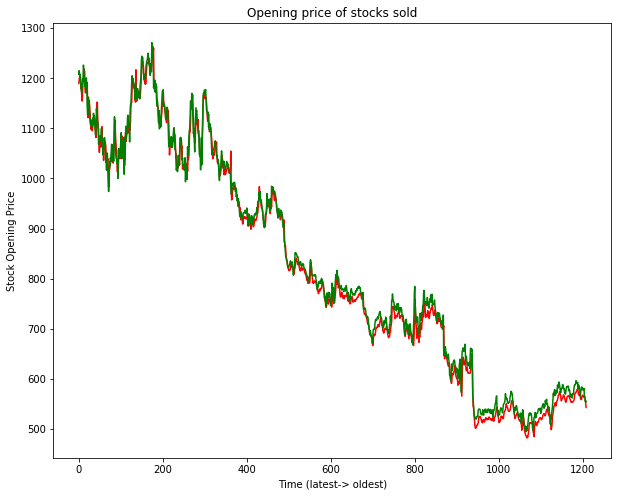

In [0]:

plt.figure(figsize=(10,8))
plt.plot(unscaled_output, color= 'red')
plt.plot(temp, color='green')
plt.title("Opening price of stocks sold")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("Stock Opening Price")
plt.show()